University of Washington

CSE 493W: Wireless Communication, Spring 2023

Author: Amit Ferman


Decodes backscattered FSK on RTL-SDR v5.

In [1]:
from rtlsdr import RtlSdr 
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision = 2)

In [2]:
try: 
    sdr.close()
    print("Closed old SDR")
except NameError:
   print("No SDR instance found")

No SDR instance found


In [3]:
sdr = RtlSdr()

### Data Collection

In [4]:
fsps = 3200000      # 1         Msps
fc = 901.9e6        # 901.9     MHz
bitrate = 80e3      # 10        ksps

dt = 1.0 / fsps
nyquist = fsps / 2.0
Tmax = 1
N = round(fsps * Tmax)

bitperiod = 1 / bitrate
sampsperbit = round(fsps / bitrate)

sdr.sample_rate = fsps 
sdr.center_freq = fc
sdr.gain = 25

print("sample size is ", N)
print("sampling rate is ", fsps)
print("center frequency is ", fc)

sample size is  3200000
sampling rate is  3200000
center frequency is  901900000.0


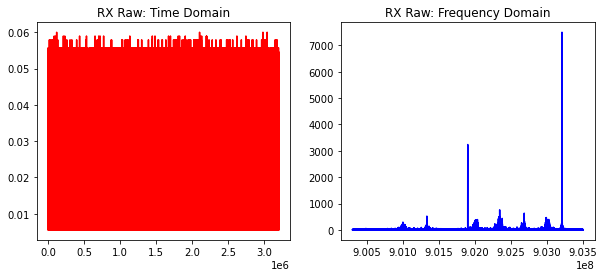

In [5]:
samples = sdr.read_samples(N)

lpf_spectrum = np.fft.fftshift(np.fft.fft(samples))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(lpf_spectrum))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("RX Raw: Time Domain")
ax1.plot(np.abs(samples), color='red')
ax2.set_title("RX Raw: Frequency Domain")
ax2.plot(freqs, np.abs(lpf_spectrum), color='blue')

### Save Data

In [6]:
prefix = "../iq_samples/iq_data_"
id = "lr20kbps"
fqn = prefix + id

np.save(fqn, samples)
# samples_loaded np.load(fqn)

### Downconversion

(0.0, 10000.0)

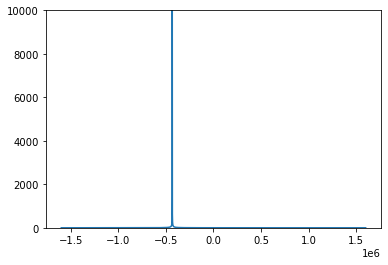

In [7]:
t = np.arange(0, N)
dfc = 0.4333333e6 # 0.4MHz
freqs = np.linspace(-nyquist,+nyquist,len(lpf_spectrum))
dsinusoid = np.exp(-2j*np.pi*t*dfc/fsps)
plt.plot(freqs, np.abs(np.fft.fftshift(np.fft.fft(dsinusoid))))
plt.ylim(0, 10000)

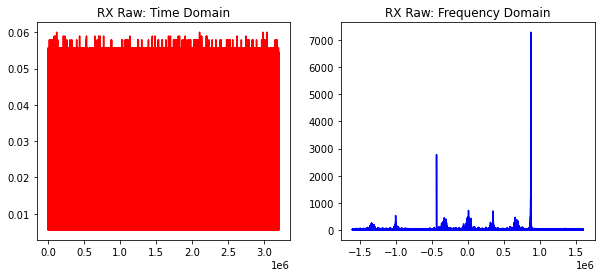

In [8]:
dsamples = dsinusoid * samples
dspectrum = np.fft.fftshift(np.fft.fft(dsamples))
freqs = np.linspace(-nyquist,+nyquist,len(dspectrum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("RX Raw: Time Domain")
ax1.plot(np.abs(dsamples), color='red')
ax2.set_title("RX Raw: Frequency Domain")
ax2.plot(freqs, np.abs(dspectrum), color='blue')

### Filter Raw I/Q Data

In [9]:
def bandpassmask(N, fsps, fcutoff):
    fnyq = fsps / 2.0
    fcutoff_nyq = fcutoff / fnyq 
    midwidth = round(fcutoff_nyq*N)
    zerowidth = int((N-midwidth)/2)
    res = np.concatenate((np.zeros(zerowidth),np.ones(midwidth),np.zeros(zerowidth)))
    res = np.concatenate((res, np.zeros(N - len(res))))
    return(res)


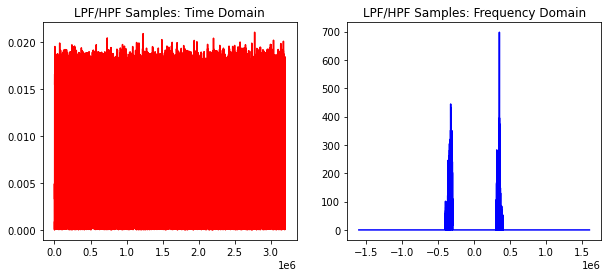

In [10]:
# lpf/hpf filtering
lpf = 0.40e6
hpf = 0.30e6
fspectrum = dspectrum  * (1 - bandpassmask(N, fsps, hpf)) * bandpassmask(N, fsps,lpf)
fsamples = np.fft.ifft(np.fft.fftshift(fspectrum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("LPF/HPF Samples: Time Domain")
ax1.plot(np.abs(fsamples), color='red')
ax2.set_title("LPF/HPF Samples: Frequency Domain")
ax2.plot(freqs, np.abs(fspectrum), color='blue')

### Decimation

In [11]:
sampsperbit

40

c:\Users\amitf\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


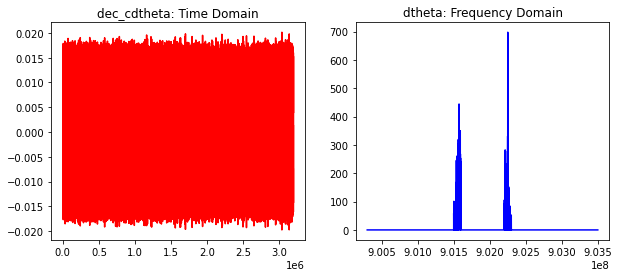

In [12]:
# decimation filtering
dec_factor = 1 # sampsperbit // 150 # we want 100 dec_sampsperbit
dec_sampsperbit = sampsperbit // dec_factor
dec_fsps = fsps // dec_factor
dec_nyquist = dec_fsps // 2
dec_N = N // dec_factor

dsamples = fsamples[::dec_factor]
dspectrum = np.fft.fftshift(np.fft.fft(dsamples))
dfreqs = np.linspace(fc-dec_nyquist, fc+dec_nyquist, dec_N)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("dec_cdtheta: Time Domain")
ax1.plot(dsamples, color='red')
ax2.set_title("dtheta: Frequency Domain")
ax2.plot(dfreqs, np.abs(dspectrum), color='blue')

In [13]:
dec_N

3200000

### Extract Instantaneous Frequency

In [14]:
filteredsignal = dsamples

In [15]:
# compute theta
theta = np.arctan2(filteredsignal.imag, filteredsignal.real) # -np.pi to np.pi

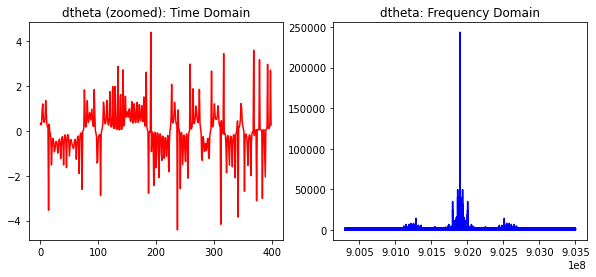

In [16]:
# compute phase derivative with 0, +pi/2 comparison to avoid edge artifacts
dt0 = np.convolve([1,-1], theta,'same')
dt1 = np.convolve([1,-1], (theta+np.pi/2) % (2*np.pi),'same')
derivtheta = np.zeros(len(dt0))

for i in range(len(dt0)):
    if (abs(dt0[i]) < abs(dt1[i])):
        derivtheta[i] = dt0[i] 
    else:
        derivtheta[i] = dt1[i] 

spectrum = np.fft.fftshift(np.fft.fft(derivtheta))
freqs = np.linspace(-dec_nyquist, +dec_nyquist, N)

a = sampsperbit*20
b = round(sampsperbit*30)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("dtheta (zoomed): Time Domain")
ax1.plot(derivtheta[a:b], color='red')
ax2.set_title("dtheta: Frequency Domain")
ax2.plot(dfreqs, np.abs(spectrum), color='blue')

c:\Users\amitf\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


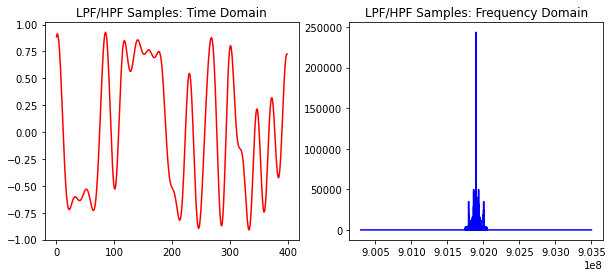

In [17]:
# lpf filtering
lpf = 0.15e6
lpf_spectrum = spectrum  * bandpassmask(dec_N, dec_fsps, lpf)
lpf_theta = np.fft.ifft(np.fft.fftshift(lpf_spectrum))

a = sampsperbit*20
b = round(sampsperbit*30)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("LPF/HPF Samples: Time Domain")
ax1.plot(lpf_theta[a:b], color='red')
ax2.set_title("LPF/HPF Samples: Frequency Domain")
ax2.plot(dfreqs, np.abs(lpf_spectrum), color='blue')

### Demodulate

In [18]:
dem = lpf_theta

In [19]:
def convolve_with_tophat(input_array, tophat_length):
    n = len(input_array)
    m = tophat_length
    tophat = np.ones(m) / m
    padded_array = np.pad(input_array, (m // 2, m // 2), mode='constant')
    result = np.zeros(n)
    for i in range(n):
        result[i] = np.sum(padded_array[i:i+m] * tophat)
    return result

In [20]:
# match filtering
dem_mf = convolve_with_tophat(dem, round(sampsperbit * 0.75))
dem_sign = np.sign(dem_mf)

C:\Users\amitf\AppData\Local\Temp\ipykernel_20864\2445009924.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  result[i] = np.sum(padded_array[i:i+m] * tophat)


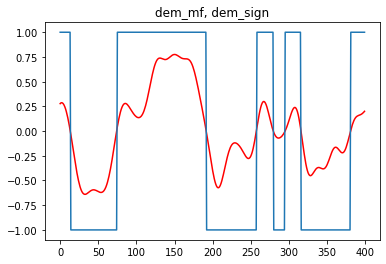

In [21]:
a = 20 * sampsperbit
b = 30 * sampsperbit
plt.title("dem_mf, dem_sign")
# plt.plot(dem[a:b])
plt.plot(dem_mf[a:b], color='red')
plt.plot(dem_sign[a:b])

In [22]:
# edge detection
win = 10
edge = win
while edge < len(dem_sign) - win:
    if np.abs(np.mean(dem_sign[edge - win:edge]) - np.mean(dem_sign[edge:edge + win])) > 1:
        break
    edge += 1

if (edge == len(dem_sign)):
    print("No edge found.")

print("edge: %d" % edge)

edge: 98


In [23]:
#sample bits
rxdata = np.array([])
i = edge + sampsperbit // 2
print(i)
while i < len(dem_sign):
    rxdata = np.concatenate((rxdata, np.array([dem_sign[i]])))
    i += sampsperbit
rxdata = (rxdata + 1) / 2


118


In [24]:
print(rxdata[0:100])

[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 1.]


### Channel Decoding

In [25]:
import sys
sys.path.append("../channel_coding/")
import channel
import bit_utils

In [26]:
encoded_bits = ''.join([str(num) for num in rxdata.astype(int)])
print(encoded_bits)

1001000000010010010111001001000001001000011011010000000000000111000110110001001110000111111001000111001001101000001110001111000111000000000010111000110110001001001100010111100100100100000100111000000011111111101100011011111100011001001001000100001001110000001110011100011101100100100000111011100110111001001101100011100011111100011100001100001111110001110011101100011000011111111001001001000111100111111111111110000100110011100001100000001111111111111111110011011001000001001110000000000000110001101000011100010011100011110000000000110010010010001100100100000110000100100001001101100100110000110010001110010010110010011000010011100000000000000011110001001000100111000000011111101100011100100100100000111000111000011000000011100010000110000100101001100001001110010010010000010011100000011111111100110001001111110001001001101100010000101111000000110111000111011001001000001110001110110010011001001101100011100011110001110000111000111111000111001110110001000001111111101100100001100011111111111100011001

In [27]:
decoded_bit_packets = channel.decode_packet_stream(encoded_bits)
decoded_bits =  ''.join(decoded_bit_packets)
decoded_plaintext = bit_utils.bits_to_string(decoded_bits)

Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corrections.
Decoded with 6 corre

In [28]:
decoded_plaintext

''

### Communication Statistics

In [29]:
packets_per_sec = len(decoded_bit_packets) / Tmax
bytes_per_sec = len(decoded_plaintext) / Tmax
bits_per_sec = bytes_per_sec * 8
useful_bit_percentage = 100 * bits_per_sec / bitrate

print("Load rate (b/s) = %d" % (bitrate))
print("Throughput (packets/sec) = %d" % (packets_per_sec))
print("Throughput (bytes/sec) = %d" % (bytes_per_sec))
print("Throughput (bits/sec) = %d" % (bits_per_sec))
print("Tput/Load Rate = %.2f%%" % (useful_bit_percentage))

Load rate (b/s) = 80000
Throughput (packets/sec) = 0
Throughput (bytes/sec) = 0
Throughput (bits/sec) = 0
Tput/Load Rate = 0.00%


In [30]:
# estimate correctness for hardcoded plaintext
actual_plaintext = "Hello, CSE 493!"
packet_bytes = 2

valid_nibbles = set()
for i in range(0, len(actual_plaintext), packet_bytes):
    valid_nibbles.add(actual_plaintext[i:i+packet_bytes])

print(valid_nibbles)

# start computing correct packets from first correct match (to align on packet length)
correct_packets = 0
matches = [decoded_plaintext.find(x) for x in valid_nibbles]
first = 0
for m in matches:
    if (m < 0):
        continue
    first = min(first, m)

print(first)
for i in range(first, len(decoded_plaintext), packet_bytes):
    if decoded_plaintext[i:i+packet_bytes] in valid_nibbles:
        correct_packets += 1

correct_packets_percentage = correct_packets / len(decoded_bit_packets) * 100

print("Goodput (bits/sec) = %d" % (correct_packets * packet_bytes * 8 / Tmax))
print("Correctness = %.2f%%" % (correct_packets_percentage))


{' 4', 'o,', 'll', '!', 'SE', ' C', '93', 'He'}
0


ZeroDivisionError: division by zero